In [16]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os

In [17]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [18]:
def get_rough_metallicity(MW_mass, MW_metal_frac, GSE_mass, GSE_metal_frac):
    MW_metal = MW_mass * MW_metal_frac
    GSE_metal = GSE_mass * GSE_metal_frac
    
    return (MW_metal + GSE_metal) / (MW_mass + GSE_mass)

In [19]:
def get_dilution_profile(snap, name, dR=2.0):

    fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
    f = h5.File(fname, mode='r')
    # print(f['PartType5'].keys())

    pos = f['PartType5/RotatedCoordinates'][:]
    vel = f['PartType5/RotatedVelocities'][:]
    ptype = f['PartType5/PartType'][:]
    mass = f['Header'].attrs['TracerMass']
    memb = f['PartType5/Membership'][:]
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    velR = vel[:,0] * cphi + vel[:,1] * sphi

    Rmin = 0.

    out = {}
    out['mass0'] = []
    out['mass1'] = []
    out['mass2'] = []
    out['mass3'] = []
    
    out['inflow0'] = []
    out['inflow1'] = []
    out['inflow2'] = []
    out['inflow3'] = []
        
    out['outflow0'] = []
    out['outflow1'] = []
    out['outflow2'] = []
    out['outflow3'] = []
    
    out['aveR'] = []
    out['area'] = []

    while Rmin < 15:
        in_annulus = np.logical_and(R > Rmin, R < Rmin+dR)
        in_annulus = np.logical_and(in_annulus, np.abs(z) < 3)
        gas_in_annulus = np.logical_and(ptype==0, in_annulus)
    
        memb0_key = np.logical_and(gas_in_annulus, memb==0)
        memb1_key = np.logical_and(gas_in_annulus, memb==1)
        memb2_key = np.logical_and(gas_in_annulus, memb==2)
        memb3_key = np.logical_and(gas_in_annulus, memb==3)
    
        mass0 = np.sum(mass * len(np.where(memb0_key)[0]))
        mass1 = np.sum(mass * len(np.where(memb1_key)[0]))
        mass2 = np.sum(mass * len(np.where(memb2_key)[0]))
        mass3 = np.sum(mass * len(np.where(memb3_key)[0]))
    
        inflow0 = np.sum(mass * velR[np.logical_and(velR < 0, memb0_key)]) / dR
        inflow1 = np.sum(mass * velR[np.logical_and(velR < 0, memb1_key)]) / dR
        inflow2 = np.sum(mass * velR[np.logical_and(velR < 0, memb2_key)]) / dR
        inflow3 = np.sum(mass * velR[np.logical_and(velR < 0, memb3_key)]) / dR
        
        outflow0 = np.sum(mass * velR[np.logical_and(velR > 0, memb0_key)]) / dR
        outflow1 = np.sum(mass * velR[np.logical_and(velR > 0, memb1_key)]) / dR
        outflow2 = np.sum(mass * velR[np.logical_and(velR > 0, memb2_key)]) / dR
        outflow3 = np.sum(mass * velR[np.logical_and(velR > 0, memb3_key)]) / dR
    
        # metal_annulus = get_rough_metallicity((0.3/0.7)*(mass0 + mass1), 10.**(-0.3)*0.0127, mass2+mass3, 10.**(-1.2)*0.0127)
    
        # metallicity.append(metal_annulus)
        # dilution.append((mass2+mass3) / (mass0 + mass1 + mass2+mass3))
        
        out['mass0'].append(mass0)
        out['mass1'].append(mass1)
        out['mass2'].append(mass2)
        out['mass3'].append(mass3)
        
        out['inflow0'].append(inflow0)
        out['inflow1'].append(inflow1)
        out['inflow2'].append(inflow2)
        out['inflow3'].append(inflow3)
        
        out['outflow0'].append(outflow0)
        out['outflow1'].append(outflow1)
        out['outflow2'].append(outflow2)
        out['outflow3'].append(outflow3)
        
        out['aveR'].append(np.mean(R[gas_in_annulus]))
        out['area'].append(np.pi * ((Rmin+dR)**2 - Rmin**2))

        Rmin += dR
    
    out['mass0'] = np.array(out['mass0'])
    out['mass1'] = np.array(out['mass1'])
    out['mass2'] = np.array(out['mass2'])
    out['mass3'] = np.array(out['mass3'])
    
    out['inflow0'] = np.array(out['inflow0'])
    out['inflow1'] = np.array(out['inflow1'])
    out['inflow2'] = np.array(out['inflow2'])
    out['inflow3'] = np.array(out['inflow3'])
        
    out['outflow0'] = np.array(out['outflow0'])
    out['outflow1'] = np.array(out['outflow1'])
    out['outflow2'] = np.array(out['outflow2'])
    out['outflow3'] = np.array(out['outflow3'])
    
    out['aveR'] = np.array(out['aveR'])
    out['area'] = np.array(out['area'])
    
    time = f['Header'].attrs['Time']

    f.close()
    
    return time, out

In [77]:
time, out = get_dilution_profile(700, 'MW3_MHG0.25_GSE6_kick-lvl4')
timeiso, outiso = get_dilution_profile(800, 'MW3iso_fg0.7_MHG0.25_RC9-lvl4')

3.5


(0.0, 14.0)

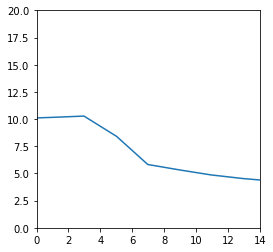

In [81]:
print(time)
dil = out['mass2']/(out['mass0'] + out['mass1'] + out['mass2'] + out['mass3'])

x = np.concatenate([[0], out['aveR']])
y = np.concatenate([[dil[0] - (dil[1]-dil[0])/(R1-R0) * R0], dil])

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(x, 100*y)
ax.set_ylim(0, 20)
ax.set_xlim(0, 14)
# ax.axhline(66.66666)
# ax.scatter(8, 66.666666, s=400)

# plt.xlabel('R [kpc]')
# plt.ylabel('dilution fraction [%]')

3.5


(0.0, 15.0)

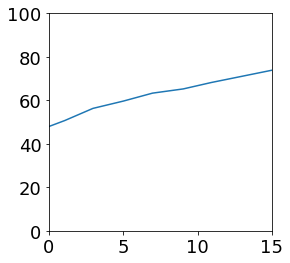

In [84]:
print(time)
dil = out['mass1']/(out['mass0'] + out['mass1'] + out['mass2'] + out['mass3'])

x = np.concatenate([[0], out['aveR']])
y = np.concatenate([[dil[0] - (dil[1]-dil[0])/(R1-R0) * R0], dil])

plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(x, 100*y)
ax.set_ylim(0, 100)
ax.set_xlim(0, 15)
# ax.axhline(66.66666)
# ax.scatter(8, 66.666666, s=400)

# plt.xlabel('R [kpc]')
# plt.ylabel('dilution fraction [%]')

In [ ]:
R0 = out['aveR'][0]
R1 = out['aveR'][1]
dil0 = dil[0]
dil1 = dil[1]

print(dil0 - (dil1-dil0)/(R1-R0) * R0)
print(dil0)


0.12877699647589605
0.12116890833468373


<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'Rotate

Text(0, 0.5, 'CGM gas inflow rate (1E10 Msun/Gyr)')

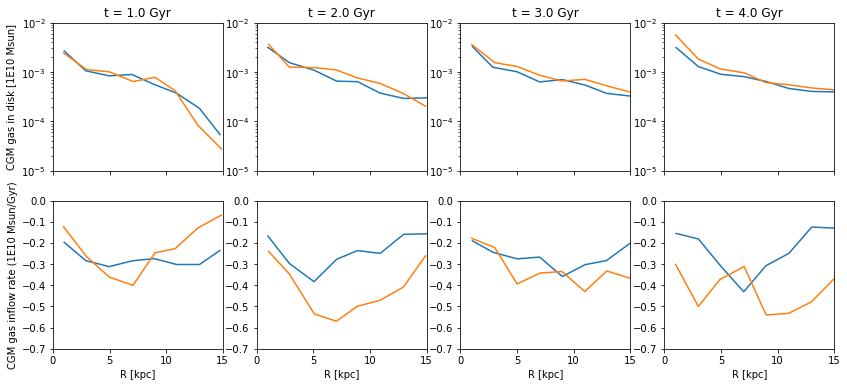

In [80]:
snap_list = [200, 400, 600, 800]

fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

for i,snap in enumerate(snap_list):
    time, out = get_dilution_profile(snap, 'MW3_MHG0.25_GSE2-lvl4')
    timeiso, outiso = get_dilution_profile(snap, 'MW3iso_fg0.7_MHG0.25_RC9-lvl4')
    
    ax[0][i].plot(outiso['aveR'], outiso['mass1']/outiso['area'])
    ax[0][i].plot(out['aveR'], out['mass1']/out['area'])
    
    ax[1][i].plot(outiso['aveR'], outiso['inflow1'])
    ax[1][i].plot(out['aveR'], out['inflow1'])
    
    ax[0][i].set_ylim(1E-5, 1E-2)
    ax[1][i].set_ylim(-0.7, 0)
    
    ax[0][i].set_title('t = '+str(time)+' Gyr')
    ax[0][i].set_yscale('log')
    ax[1][i].set_xlabel('R [kpc]')
    
ax[0][0].set(xlim=(0, 15))
ax[0][0].set_ylabel('CGM gas in disk [1E10 Msun]')
ax[1][0].set_ylabel('CGM gas inflow rate (1E10 Msun/Gyr)')


<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'NumberDensity', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'Temperature', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'NumberDensity', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'Temperature', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'NumberDensity', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'Tem

Text(0, 0.5, 'CGM gas inflow rate (1E10 Msun/Gyr)')

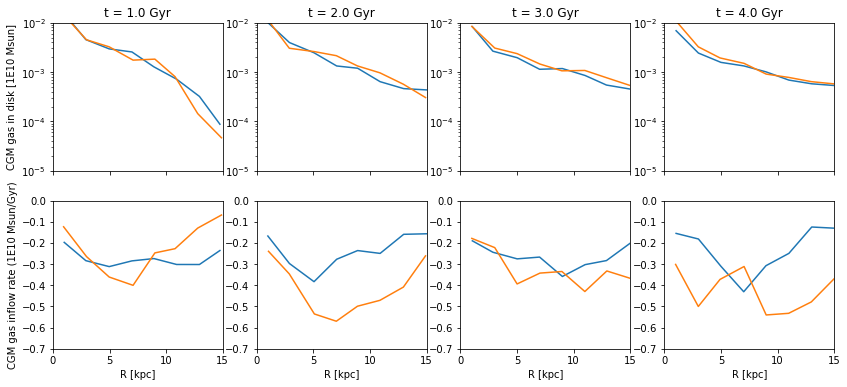

In [8]:
snap_list = [200, 400, 600, 800]

fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

for i,snap in enumerate(snap_list):
    time, out = get_dilution_profile(snap, 'MW3_MHG0.25_GSE2-lvl4')
    timeiso, outiso = get_dilution_profile(snap, 'MW3iso_fg0.7_MHG0.25_RC9-lvl4')
    
    ax[0][i].plot(outiso['aveR'], (outiso['mass0']+outiso['mass1']+outiso['mass2']+outiso['mass3'])/outiso['area'])
    ax[0][i].plot(out['aveR'], (out['mass0']+out['mass1']+out['mass2']+out['mass3'])/out['area'])
    
    ax[1][i].plot(outiso['aveR'], outiso['inflow1'])
    ax[1][i].plot(out['aveR'], out['inflow1'])
    
    ax[0][i].set_ylim(1E-5, 1E-2)
    ax[1][i].set_ylim(-0.7, 0)
    
    ax[0][i].set_title('t = '+str(time)+' Gyr')
    ax[0][i].set_yscale('log')
    ax[1][i].set_xlabel('R [kpc]')
    
ax[0][0].set(xlim=(0, 15))
ax[0][0].set_ylabel('CGM gas in disk [1E10 Msun]')
ax[1][0].set_ylabel('CGM gas inflow rate (1E10 Msun/Gyr)')


<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'NumberDensity', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'Temperature', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'NumberDensity', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'Temperature', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>
<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Membership', 'NumberDensity', 'ParentID', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'Tem

Text(0, 0.5, 'CGM gas inflow rate (1E10 Msun/Gyr)')

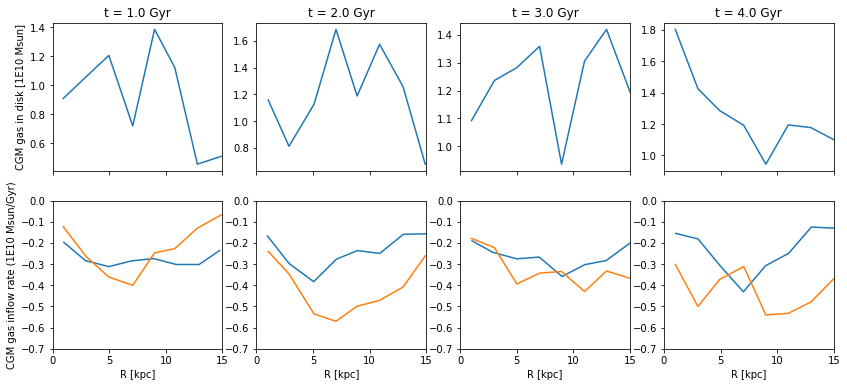

In [12]:
snap_list = [200, 400, 600, 800]

fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

for i,snap in enumerate(snap_list):
    time, out = get_dilution_profile(snap, 'MW3_MHG0.25_GSE2-lvl4')
    timeiso, outiso = get_dilution_profile(snap, 'MW3iso_fg0.7_MHG0.25_RC9-lvl4')
    
    # ax[0][i].plot(outiso['aveR'], (outiso['mass0']+outiso['mass1']+outiso['mass2']+outiso['mass3'])/outiso['area'])
    ax[0][i].plot(out['aveR'], (out['mass1']/(outiso['mass1'])))
    
    ax[1][i].plot(outiso['aveR'], outiso['inflow1'])
    ax[1][i].plot(out['aveR'], out['inflow1'])
    
    # ax[0][i].set_ylim(1E-5, 1E-2)
    ax[1][i].set_ylim(-0.7, 0)
    
    ax[0][i].set_title('t = '+str(time)+' Gyr')
    # ax[0][i].set_yscale('log')
    ax[1][i].set_xlabel('R [kpc]')
    
ax[0][0].set(xlim=(0, 15))
ax[0][0].set_ylabel('CGM gas in disk [1E10 Msun]')
ax[1][0].set_ylabel('CGM gas inflow rate (1E10 Msun/Gyr)')


3it [00:21,  7.33s/it]


OSError: Unable to open file (unable to open file: name = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/anlys/MC/MW3_MHG0.25_GSE6_kick-lvl4/MC_Prop_800.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

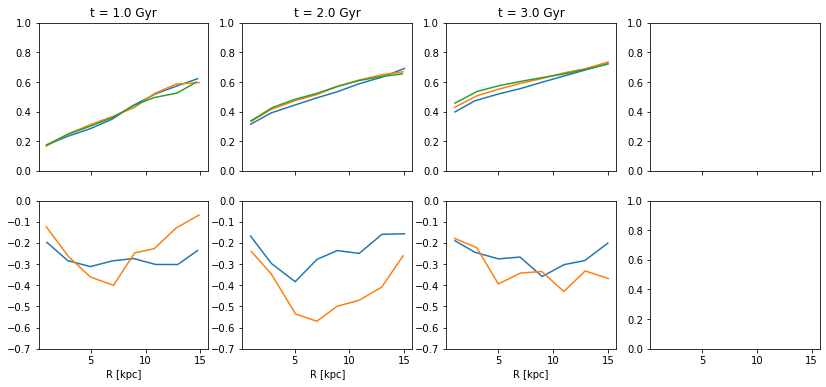

In [15]:
snap_list = [200, 400, 600, 800]

fig, ax = plt.subplots(2, 4, figsize=(14, 6), sharex=True)

for i,snap in tqdm(enumerate(snap_list)):
    time, out = get_dilution_profile(snap, 'MW3_MHG0.25_GSE2-lvl4')
    timekick, outkick = get_dilution_profile(snap, 'MW3_MHG0.25_GSE6_kick-lvl4')
    timeiso, outiso = get_dilution_profile(snap, 'MW3iso_fg0.7_MHG0.25_RC9-lvl4')
    
    ax[0][i].plot(outiso['aveR'], outiso['mass1']/(outiso['mass0'] + outiso['mass1'] + outiso['mass2']))
    ax[0][i].plot(out['aveR'], out['mass1']/(out['mass0'] + out['mass1'] + out['mass2']))
    ax[0][i].plot(outkick['aveR'], outkick['mass1']/(outkick['mass0'] + outkick['mass1'] + outkick['mass2']))
    
    ax[1][i].plot(outiso['aveR'], outiso['inflow1'])
    ax[1][i].plot(out['aveR'], out['inflow1'])
    
    # ax[0][i].set_ylim(1E-5, 1E-2)
    ax[0][i].set_ylim(0, 1)
    ax[1][i].set_ylim(-0.7, 0)
    
    ax[0][i].set_title('t = '+str(time)+' Gyr')
    # ax[0][i].set_yscale('log')
    ax[1][i].set_xlabel('R [kpc]')
    
ax[0][0].set(xlim=(0, 15))
ax[0][0].set_ylabel('CGM gas in disk [1E10 Msun]')
ax[1][0].set_ylabel('CGM gas inflow rate (1E10 Msun/Gyr)')


In [61]:
time, out = get_dilution_profile(300, 'MW3_MHG0.25_GSE6_kick-lvl4')
timeiso, outiso = get_dilution_profile(300, 'MW3iso_fg0.7_MHG0.25_RC9-lvl4')

(0.0, 0.15)

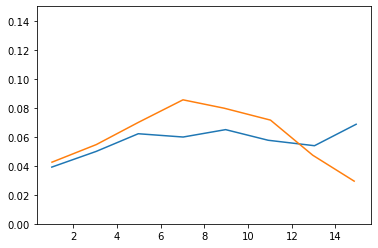

In [62]:
plt.plot(outiso['aveR'], outiso['mass1'])
# plt.plot(outiso['aveR'], outiso['mass0'])

plt.plot(out['aveR'], out['mass1'])
# plt.plot(out['aveR'], out['mass0'])

plt.ylim(0, 0.15)

plt.plot(outiso['aveR'], outiso['mass1'])
# plt.plot(outiso['aveR'], outiso['mass0'])

plt.plot(out['aveR'], out['mass1'])
# plt.plot(out['aveR'], out['mass0'])

plt.ylim(0, 0.15)

# What if gas is not all mixed?

In [69]:
name = 'MW3_MHG0.25_GSE2_MHG0.18_Rcut10-lvl4'
snap = 1000
fname = basepath + 'anlys/MC/'+name+'/MC_Prop_'+str(snap).zfill(3)+'.h5'
f = h5.File(fname, mode='r')

In [70]:
f['PartType5'].keys()

<KeysViewHDF5 ['Coordinates', 'GFM_Metallicity', 'Masses', 'Membership', 'PartType', 'RotatedCoordinates', 'RotatedVelocities', 'TracerID', 'Velocities']>

In [86]:
pos = f['PartType5']['RotatedCoordinates'][:]
R = np.linalg.norm(pos[:,:2], axis=1)
z = pos[:,2]
memb = f['PartType5']['Membership'][:]

In [130]:
zsort = np.sort(z)
zuniq = np.unique(zsort)
num_memb = np.zeros((len(zuniq), 4), dtype=int)
memb_sort = memb[np.argsort(z)]

i=j=0
while i < len(z):
    if zsort[i] == zuniq[j]:
        num_memb[j][memb_sort[i]] += 1
        i += 1
    else:
        j += 1
        

0.009703658966454797


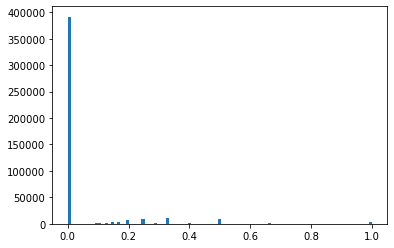

In [135]:
num_MW = num_memb[:,0] + num_memb[:,1]
num_GSE = num_memb[:,2] + num_memb[:,3]
Rsort = R[np.argsort(z)]
Runiq = np.unique(Rsort)
in_disk = np.logical_and(Runiq < 15, np.abs(zuniq) < 3)

plt.hist(num_GSE[in_disk]/(num_GSE[in_disk]+num_MW[in_disk]), bins=np.linspace(0, 1, 100));
print(len(np.where(num_MW[in_disk] == 0)[0])/len(np.where(in_disk)[0]))

In [99]:
np.unique(num_GSE/(num_GSE+num_MW))

array([0., 1.])

(array([   0., 1177., 2938., 4880., 5068., 3831., 2196., 1099.,  430.,
         209.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

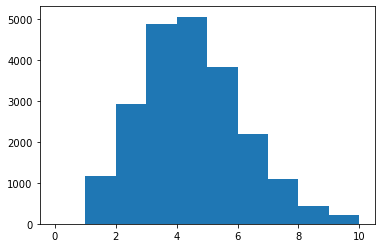

In [103]:
plt.hist(num_GSE[num_GSE>0], bins=np.linspace(0, 10, 11))

In [113]:
Rsort = R[np.argsort(z)]
Runiq = np.unique(Rsort)
print(len(Runiq), len(zuniq), len(num_GSE))
in_disk = np.logical_and(Runiq < 15, np.abs(zuniq) < 3)

num_GSE[in_disk][:10000]

937549 937549 937549


array([0, 0, 0, ..., 0, 0, 0])

In [115]:
Runiq[np.where(num_GSE>0)]

array([306.7658567 , 306.76851203, 306.76962372, ..., 543.06902182,
       544.98084927, 552.22067253])

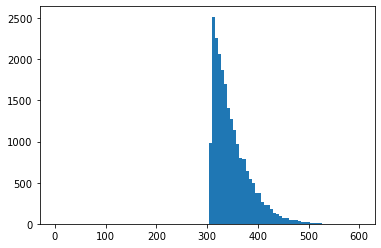

In [128]:
plt.hist(Runiq[num_GSE>0], bins=np.linspace(0, 600, 100));

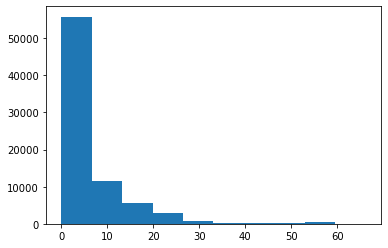

In [129]:
pos = f['PartType5/RotatedCoordinates'][:]
R = np.linalg.norm(pos[:,:2], axis=1)
memb = f['PartType5/Membership'][:]
plt.hist(R[memb==2]);